# Importing Packages

In [ ]:
# Installing Keras Tuner - if needed for local machine

!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Import all necessary packages

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from math import sqrt
from kerastuner import HyperModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import boxcox1p
from kerastuner.tuners import RandomSearch

<ipython-input-2-3c5a676f93c5>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


# Importing Data and Data Cleaning

In [ ]:
# Importing the data - predictor and response variables

predictor_data = pd.read_excel('modis_weather_data.xlsx')
soybean_data = pd.read_excel('simplified_soybean_yield_data.xlsx')

In [ ]:
# A quick examination of the predictor data

predictor_data.head()

,county,year,precipitation,min_temp,avg_temp,max_temp,ndvi_avg_value,evi_avg_value,lai_avg_value
0,Alamance,2000.0,40.50,47.1,58.4,69.8,5619.401088,2769.250359,18.101840
1,Alamance,2001.0,33.08,47.5,59.4,71.3,5233.747794,2753.023189,18.598773
2,Alamance,2002.0,47.76,48.3,59.8,71.4,6656.464546,3768.941720,20.294070
3,Alamance,2003.0,69.12,48.1,58.4,68.7,5854.138225,2976.035091,18.346421
4,Alamance,2004.0,48.65,48.9,59.3,69.8,6354.528627,3272.060435,20.823313


In [ ]:
# Clearning up the predictor data a bit by changing variable type to numeric

columns_to_convert = ['year', 'precipitation', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value']
for column in columns_to_convert:
    predictor_data[column] = pd.to_numeric(predictor_data[column], errors='coerce')

predictor_data['year'] = predictor_data['year'].fillna(0).astype(int)

# Checking to make sure that all the columns now have the appropriate data type
print(predictor_data.dtypes)

county             object
year                int64
precipitation     float64
min_temp          float64
avg_temp          float64
max_temp          float64
ndvi_avg_value    float64
evi_avg_value     float64
lai_avg_value     float64
dtype: object


In [ ]:
# Filter out rows where 'county' contains more than one word, essentially removing values such as "Other Counties"
soybean_data_filtered = soybean_data[~soybean_data['county'].str.contains(' ')]

# Minor formatting to make it so each county name is only capitalized
soybean_data_filtered['county'] = soybean_data_filtered['county'].str.title()

<ipython-input-9-69ab65cb655d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soybean_data_filtered['county'] = soybean_data_filtered['county'].str.title()


In [ ]:
# Checking to make sure the changes were successful

soybean_data_filtered.head()

,year,county,soybean_yield
1,2022,Beaufort,48.1
2,2022,Craven,41.7
3,2022,Greene,40.3
4,2022,Hyde,50.0
5,2022,Johnston,30.3


In [ ]:
# Merging our data frames together based on year and county
final_data = pd.merge(predictor_data, soybean_data_filtered, on=['year', 'county'], how='left')

# Display the first few rows to check the result
print(final_data.head())

     county  year  precipitation  min_temp  avg_temp  max_temp  \
0  Alamance  2000          40.50      47.1      58.4      69.8   
1  Alamance  2001          33.08      47.5      59.4      71.3   
2  Alamance  2002          47.76      48.3      59.8      71.4   
3  Alamance  2003          69.12      48.1      58.4      68.7   
4  Alamance  2004          48.65      48.9      59.3      69.8   

   ndvi_avg_value  evi_avg_value  lai_avg_value  soybean_yield  
0     5619.401088    2769.250359      18.101840           34.0  
1     5233.747794    2753.023189      18.598773           31.0  
2     6656.464546    3768.941720      20.294070           23.0  
3     5854.138225    2976.035091      18.346421           29.0  
4     6354.528627    3272.060435      20.823313           36.0  


In [ ]:
# Removing rows that didn't have a "match", indicating that the county did not report soybean yield or were contained within "Other Counties"

final_data_cleaned = final_data.dropna(subset=['soybean_yield'])

In [ ]:
# Changing the year back into an integer, just in case this was accidentally altered

final_data_cleaned['year'] = final_data_cleaned['year'].fillna(0).astype(int)

<ipython-input-13-3e03661c9d9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_cleaned['year'] = final_data_cleaned['year'].fillna(0).astype(int)


In [ ]:
# Adding in a variable to account for the passage of time since soybean yields have been increasing in every county over the 20 years

final_data_cleaned['time_trend'] = final_data_cleaned['year'] - final_data_cleaned['year'].min()

<ipython-input-14-1c98b977682b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_cleaned['time_trend'] = final_data_cleaned['year'] - final_data_cleaned['year'].min()


In [ ]:
# Quick check of the final data

final_data_cleaned.head()

,county,year,precipitation,min_temp,avg_temp,max_temp,ndvi_avg_value,evi_avg_value,lai_avg_value,soybean_yield,time_trend
0,Alamance,2000,40.50,47.1,58.4,69.8,5619.401088,2769.250359,18.101840,34.0,0
1,Alamance,2001,33.08,47.5,59.4,71.3,5233.747794,2753.023189,18.598773,31.0,1
2,Alamance,2002,47.76,48.3,59.8,71.4,6656.464546,3768.941720,20.294070,23.0,2
3,Alamance,2003,69.12,48.1,58.4,68.7,5854.138225,2976.035091,18.346421,29.0,3
4,Alamance,2004,48.65,48.9,59.3,69.8,6354.528627,3272.060435,20.823313,36.0,4


In [ ]:
# Determining the range of possible soybean yield values

max_value = final_data_cleaned['soybean_yield'].max()
min_value = final_data_cleaned['soybean_yield'].min()

print("Maximum Value:", max_value)
print("Minimum Value:", min_value)

Maximum Value: 57.0
Minimum Value: 7.0


# Outlier Detection

In [ ]:
# Conducting an analysis to determine the number of outliers in the dataset

numeric_cols = final_data_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Z-Score
z_scores = np.abs(stats.zscore(final_data_cleaned[numeric_cols]))
outliers_z = np.where(z_scores > 3)

# IQR Score
Q1 = final_data_cleaned[numeric_cols].quantile(0.25)
Q3 = final_data_cleaned[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((final_data_cleaned[numeric_cols] < (Q1 - 1.5 * IQR)) | (final_data_cleaned[numeric_cols] > (Q3 + 1.5 * IQR)))
outliers_iqr = outlier_condition.any(axis=1)

# Combining both methods to identify outliers
outliers_combined = set(outliers_z[0]) | set(final_data_cleaned[outliers_iqr].index)

# To drop the outliers from the original DataFrame - this was ultimately not done for this study
#final_data_outliers = final_data_cleaned.drop(list(outliers_combined))

print(len(outliers_combined))

In [ ]:
# Creating box plots to examine the distribution of values for precipitation and lai_avg_value

# precipitation:
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.boxplot(x=final_data_cleaned['precipitation'])
plt.title('Box Plot of Precipitation')
plt.xlabel('Precipitation')
plt.show()

# lai_avg_value:
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.boxplot(x=final_data_cleaned['lai_avg_value'])
plt.title('Box Plot of lai_avg_value')
plt.xlabel('lai_avg_value')
plt.show()

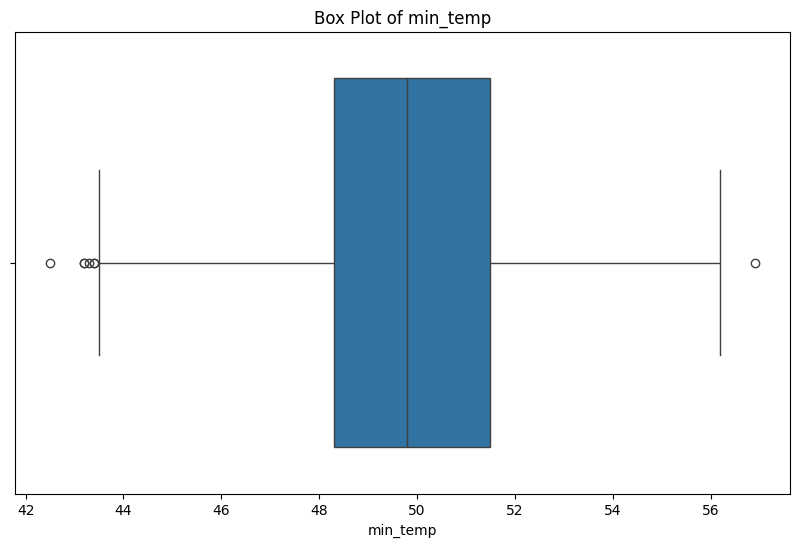

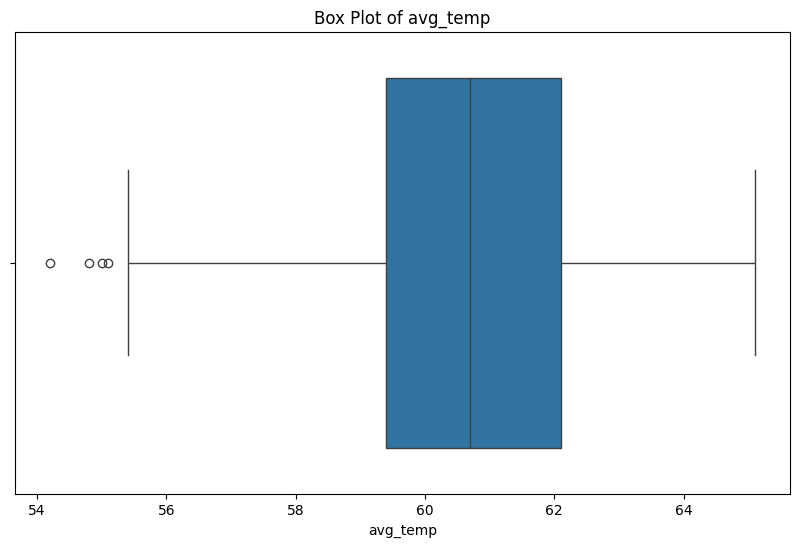

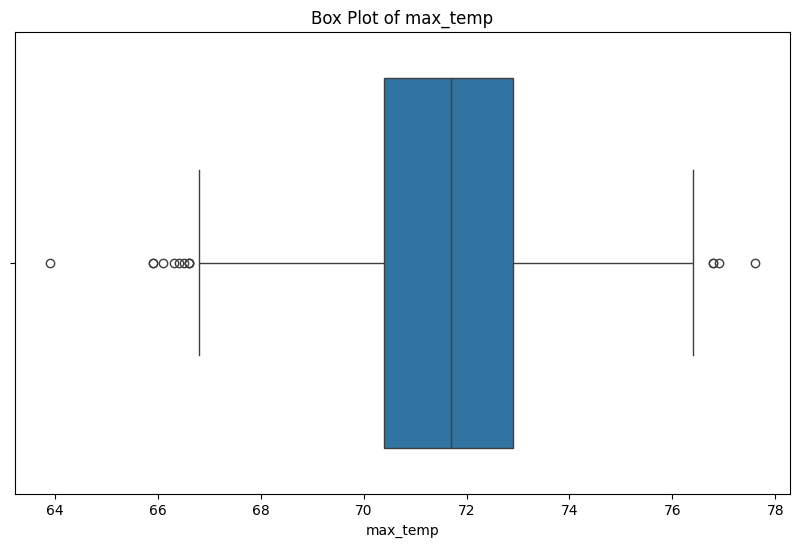

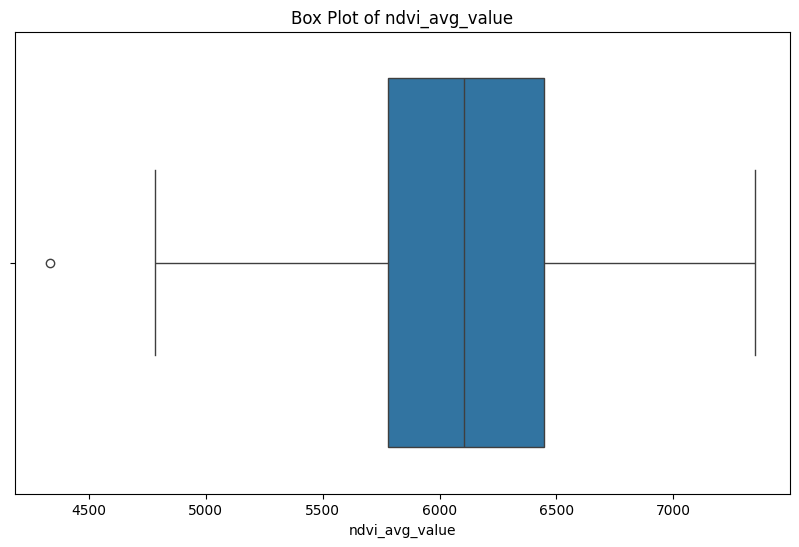

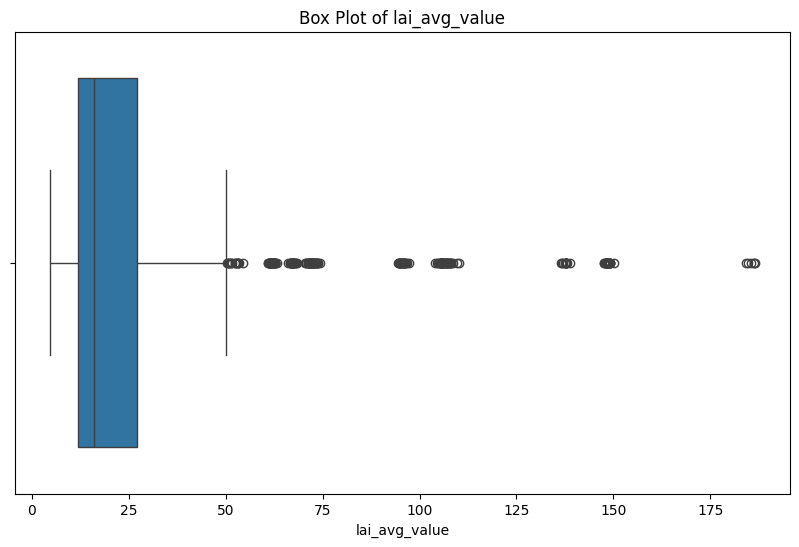

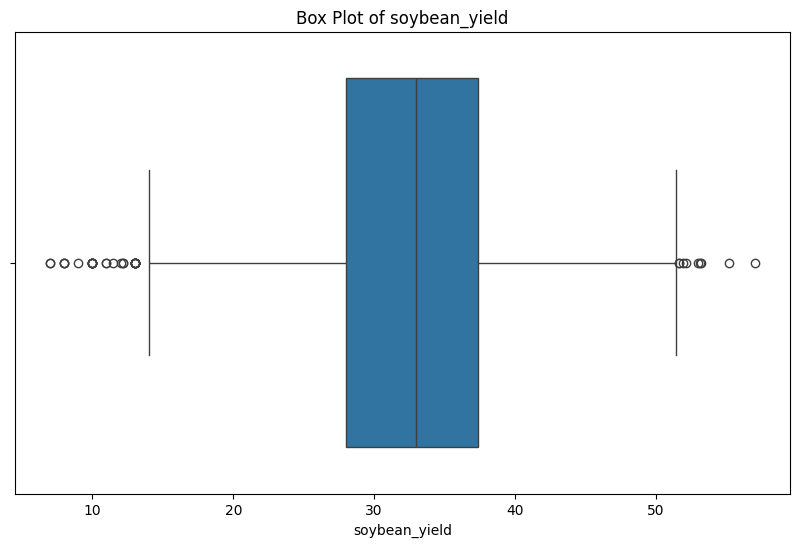

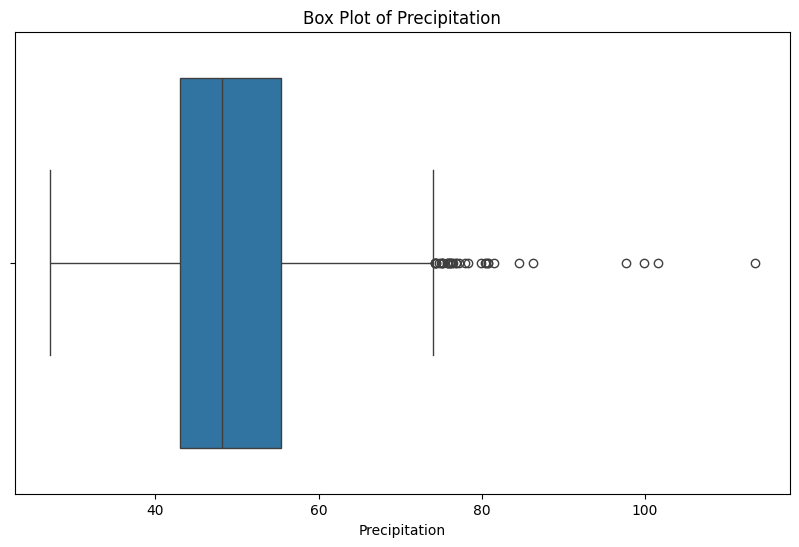

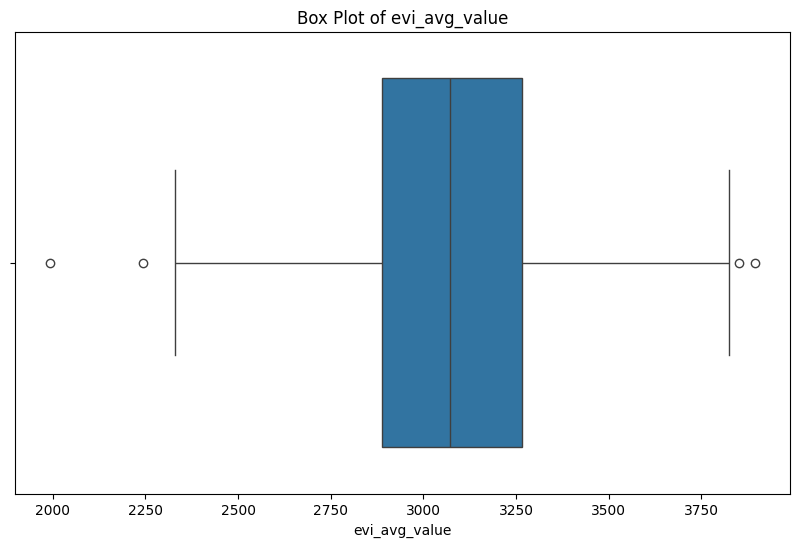

In [ ]:
# Creating box plots for all predictor variables in order to visualize the distribution and identify outlier intensity

# min_temp:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['min_temp'])
plt.title('Box Plot of min_temp')
plt.xlabel('min_temp')
plt.show()

# avg_temp:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['avg_temp'])
plt.title('Box Plot of avg_temp')
plt.xlabel('avg_temp')
plt.show()

# max_temp:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['max_temp'])
plt.title('Box Plot of max_temp')
plt.xlabel('max_temp')
plt.show()

# nvdi_avg_value:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['ndvi_avg_value'])
plt.title('Box Plot of ndvi_avg_value')
plt.xlabel('ndvi_avg_value')
plt.show()

# lai_avg_value:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['lai_avg_value'])
plt.title('Box Plot of lai_avg_value')
plt.xlabel('lai_avg_value')
plt.show()

# soybean_yield:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['soybean_yield'])
plt.title('Box Plot of soybean_yield')
plt.xlabel('soybean_yield')
plt.show()

# precipitation:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['precipitation'])
plt.title('Box Plot of Precipitation')
plt.xlabel('Precipitation')
plt.show()

# evi_avg_value:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['evi_avg_value'])
plt.title('Box Plot of evi_avg_value')
plt.xlabel('evi_avg_value')
plt.show()

### Box-Cox Transformation

<ipython-input-20-0e401aa5eff7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_cleaned['precipitation_bc'], fitted_lambda = boxcox(final_data_cleaned['precipitation'])


Fitted Lambda:  -0.14653847712971788


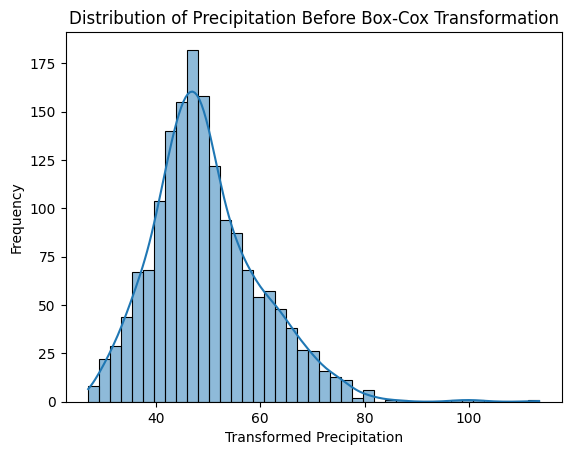

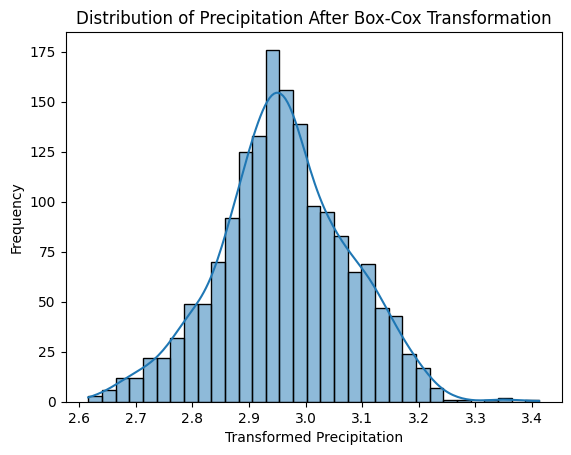

In [ ]:
# BCT for Precipitation

# Apply Box-Cox transformation
final_data_cleaned['precipitation_bc'], fitted_lambda = boxcox(final_data_cleaned['precipitation'])

print("Fitted Lambda: ", fitted_lambda)

# Visualize the original distribution
sns.histplot(final_data_cleaned['precipitation'], kde=True)
plt.title('Distribution of Precipitation Before Box-Cox Transformation')
plt.xlabel('Transformed Precipitation')
plt.ylabel('Frequency')
plt.show()

# Visualize to check the effect
sns.histplot(final_data_cleaned['precipitation_bc'], kde=True)
plt.title('Distribution of Precipitation After Box-Cox Transformation')
plt.xlabel('Transformed Precipitation')
plt.ylabel('Frequency')
plt.show()

<ipython-input-21-ffa40d31eb55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_cleaned['lai_avg_value_bc'], fitted_lambda = boxcox(final_data_cleaned['lai_avg_value'])


Fitted Lambda:  -0.7100548297319647


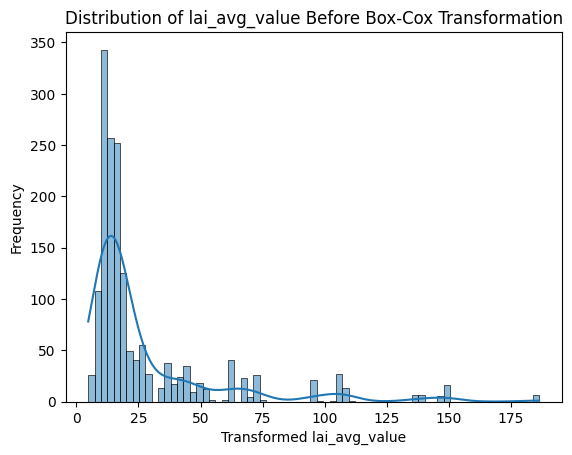

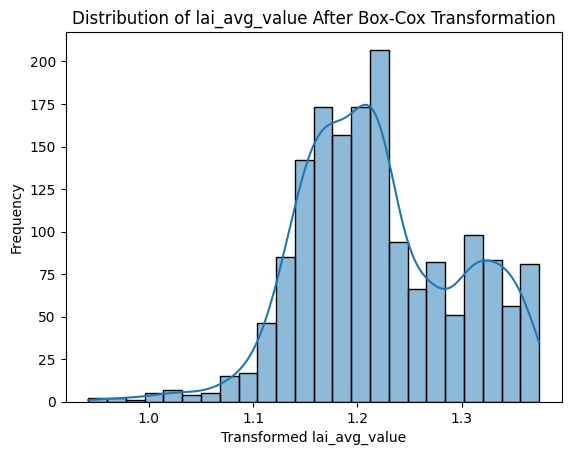

In [ ]:
#BCT for LAI

# Apply Box-Cox transformation
final_data_cleaned['lai_avg_value_bc'], fitted_lambda = boxcox(final_data_cleaned['lai_avg_value'])

print("Fitted Lambda: ", fitted_lambda)

# Visualize the original distribution
sns.histplot(final_data_cleaned['lai_avg_value'], kde=True)
plt.title('Distribution of lai_avg_value Before Box-Cox Transformation')
plt.xlabel('Transformed lai_avg_value')
plt.ylabel('Frequency')
plt.show()

# Visualize to check the effect
sns.histplot(final_data_cleaned['lai_avg_value_bc'], kde=True)
plt.title('Distribution of lai_avg_value After Box-Cox Transformation')
plt.xlabel('Transformed lai_avg_value')
plt.ylabel('Frequency')
plt.show()

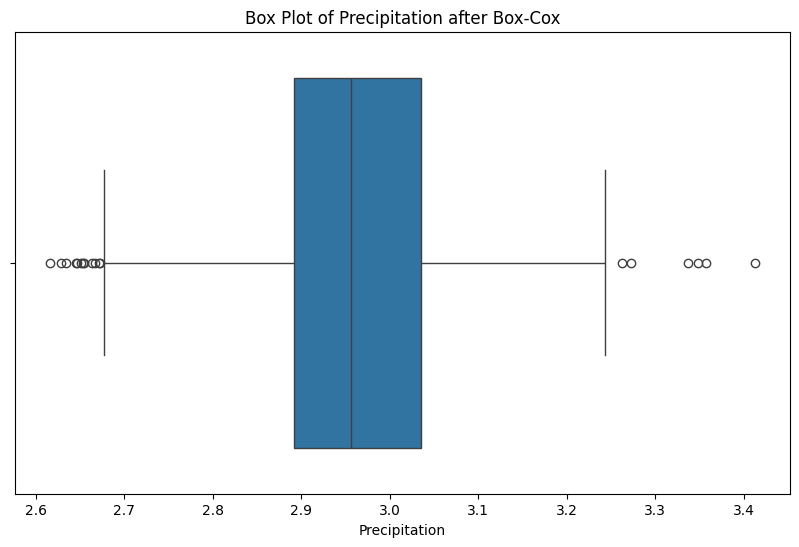

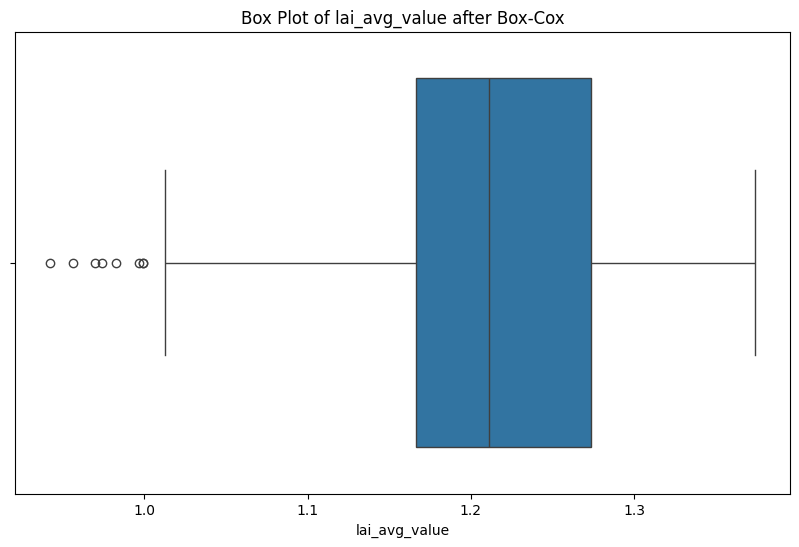

In [ ]:
# Creating post Box-Cox boxplots

# precipitation:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['precipitation_bc'])
plt.title('Box Plot of Precipitation after Box-Cox')
plt.xlabel('Precipitation')
plt.show()

# lai_avg_value:
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_data_cleaned['lai_avg_value_bc'])
plt.title('Box Plot of lai_avg_value after Box-Cox')
plt.xlabel('lai_avg_value')
plt.show()

# Preparing Training and Testing data

In [ ]:
# Preparing the data by sorting by year

final_data_cleaned.sort_values(by='year', inplace=True)

<ipython-input-22-e084da377555>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_cleaned.sort_values(by='year', inplace=True)


In [ ]:
# Splitting the data

# Define the split year
split_year = 2018

# Split the data
train = final_data_cleaned[final_data_cleaned['year'] < split_year]
test = final_data_cleaned[final_data_cleaned['year'] >= split_year]

# Define predictors and target
X_train = train[['precipitation', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value', 'time_trend']]
y_train = train['soybean_yield']
X_test = test[['precipitation', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value', 'time_trend']]
y_test = test['soybean_yield']


# Applying Min-Max Scaling - ultimately not used in the study
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# For conducting a PCA - ultimately not used in the study

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features: {X_train_pca.shape[1]}")

Original number of features: 8
Reduced number of features: 5


# Setting up the models

## Linear Regression

In [ ]:
# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = lin_reg.predict(X_test)

# Calculate MSE and RMSE
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = sqrt(mse_linear)

# Print the performance metrics
print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression RMSE: {rmse_linear}")

print(f"Intercept: {lin_reg.intercept_}")
print(f"Coefficients: {lin_reg.coef_}")

Linear Regression MSE: 40.358250840768264
Linear Regression RMSE: 6.352814403141986
Intercept: 97.54841986332497
Coefficients: [ 0.12053948 -0.4733114   0.98424818 -1.23200258 -0.00316358 -0.00179226
  0.04403836  0.40702078]


## Random Forest

In [ ]:
# Random Forest: initial base model with scaled data

# Initialize the model
rf_model_us = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
rf_model_us.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf_us = rf_model_us.predict(X_test_scaled)

# Evaluate the model
mse_rf_us = mean_squared_error(y_test, y_pred_rf_us)
print(f"Random Forest base MSE: {mse_rf_us}")

Random Forest base MSE: 43.41645976787611


In [ ]:
# Random Forest: initial base model with unscaled data

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest base MSE: {mse_rf}")

Random Forest base MSE: 43.41688886147493


### RF: RandomSearch (best)

In [ ]:
# Random Forest: Refining and hyperparameter tuning

# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Initialize the RandomizedSearchCV object

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
# Let's see which parameters are the best

rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [ ]:
# Best parameter set found
print("Best parameters found: ", rf_random.best_params_)

# Best estimator directly
best_rf_model = rf_random.best_estimator_

# Predict on the test set using the best model
y_pred_rf_best = rf_random.predict(X_test)

# Evaluate the best model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
print(f"Refined Random Forest MSE: {mse_rf_best}")

Best parameters found:  {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
Refined Random Forest MSE: 39.48462029810493


In [ ]:
rmse_rf_best = sqrt(mse_rf_best)
print(rmse_rf_best)

6.2836788824783945


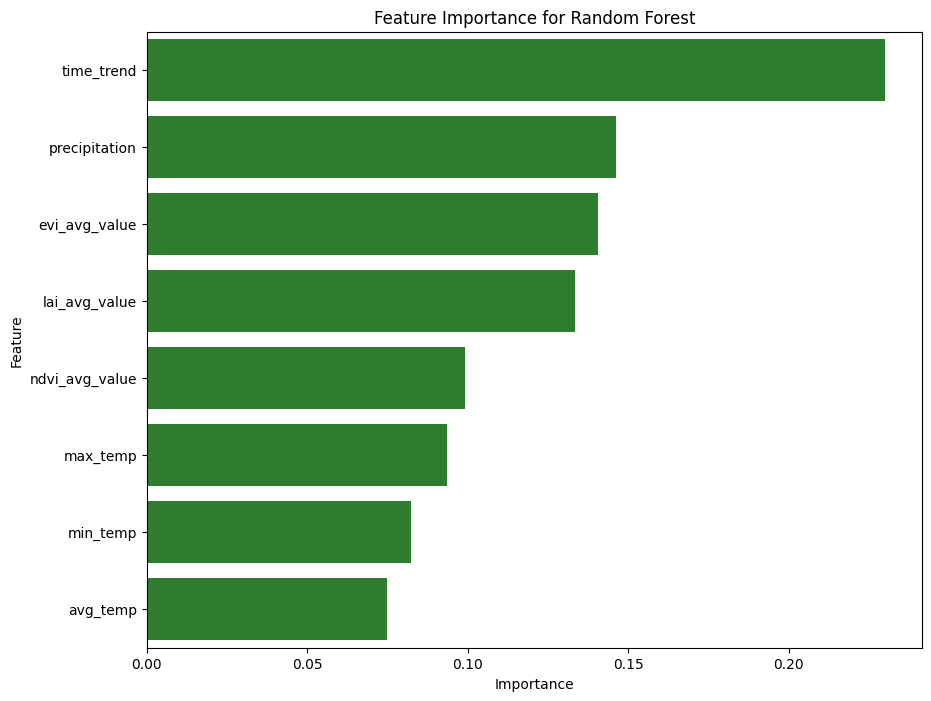

In [ ]:
# Seeing which features were the most important in prediction

# Now you can access feature_importances_ attribute from the best estimator
feature_importances = best_rf_model.feature_importances_

features = list(X_train.columns)
importance_scores = list(feature_importances)
feature_importance_dict = dict(zip(features, importance_scores))

sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert the sorted features into a DataFrame for easier plotting
feature_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Create the plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df, color = 'forestgreen')
plt.title('Feature Importance for Random Forest')
plt.show()


### RF: GridSearchCV

In [ ]:
# Initialize the GridSearchCV object
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3,
                              verbose=2,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


KeyboardInterrupt: 

In [ ]:
# Best parameter set found
print("Best parameters found: ", rf_grid_search.best_params_)

# Best estimator directly
best_rf_model = rf_grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_rf_best = best_rf_model.predict(X_test_scaled)

# Evaluate the best model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
print(f"Refined Random Forest MSE: {mse_rf_best}")

In [ ]:
# Determining feature importance

feature_names = ['precipitation', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value']

# After fitting the best model, get the feature importances
feature_importances = best_rf_model.feature_importances_

# Create a pandas Series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance
sorted_importances = importances.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


### Incorporating PCA in RF model

In [ ]:
pipeline_steps = [
    ('pca', PCA(n_components=0.95)),  # Retain 95% of variance
    ('rf', RandomForestRegressor(random_state=42))
]

# Create a pipeline
pipeline = Pipeline(steps=pipeline_steps)

# Creating parameter grid for GridSearchCV to work with
param_grid_rf = {
    'pca__n_components': [0.95, 0.9, 0.85],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

In [ ]:
rf_grid_search = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid_rf,
                              cv=3,
                              verbose=2,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error')

In [ ]:
rf_grid_search.fit(X_train_scaled, y_train)
# Best parameter set found
print("Best parameters found: ", rf_grid_search.best_params_)

In [ ]:
# Best estimator directly
best_rf_pipeline = rf_grid_search.best_estimator_

# Predict on the test set using the best model from the grid search
y_pred_rf_best = best_rf_pipeline.predict(X_test_scaled)

# Evaluate the best model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
rmse_rf_best = sqrt(mse_rf_best)
print(f"Refined Random Forest with PCA MSE: {mse_rf_best}")
print(f"Refined Random Forest with PCA RMSE: {rmse_rf_best}")

## XGBoost

In [ ]:
# Initialize the base XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")

XGBoost MSE: 43.25966382448449


### XGB: Random Search (best)

In [ ]:
# Define the parameter grid to search
param_dist_xgb = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'learning_rate': np.logspace(-3, 0, 4),
    'max_depth': [int(x) for x in np.linspace(3, 10, 8)],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

In [ ]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=param_dist_xgb,
                                       n_iter=100,
                                       scoring='neg_mean_squared_error',
                                       cv=3,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

In [ ]:
# Fit RandomizedSearchCV on unscaled data
xgb_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Best parameters and model
print("Best parameters found: ", xgb_random_search.best_params_)
best_xgb_model = xgb_random_search.best_estimator_

# Predict on the test set
y_pred_xgb_best = best_xgb_model.predict(X_test)

# Evaluate the model
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
print(f"Optimized XGBoost MSE: {mse_xgb_best}")

Best parameters found:  {'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
Optimized XGBoost MSE: 40.19190952138617


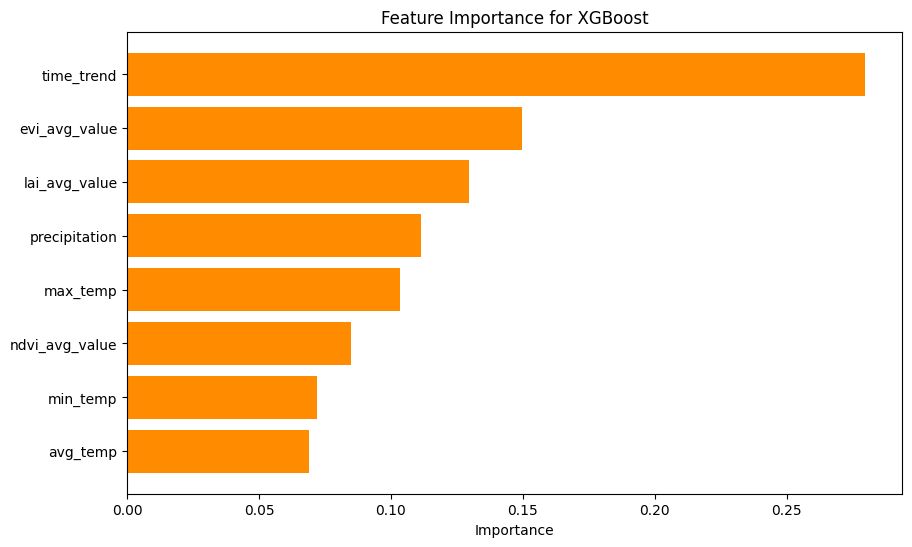

In [ ]:
# Get feature importances
importance_xgb = best_xgb_model.feature_importances_

feature_names_xgb = X_train.columns

feature_importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': importance_xgb
})

# Sort the features by importance
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_xgb['Feature'], feature_importance_df_xgb['Importance'], color='darkorange')
plt.xlabel('Importance')
plt.title('Feature Importance for XGBoost')
plt.gca().invert_yaxis()
plt.show()


### XGB: GridSearchCV

In [ ]:
# XGBoost: Refining and hyperparameter tuning

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

In [ ]:
# Initialize the GridSearchCV object
xgb_grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid_xgb,
                               cv=3,
                               verbose=2,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Best parameter set found
print("Best parameters found: ", xgb_grid_search.best_params_)

# Best estimator directly
best_xgb_model_gs = xgb_grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_xgb_best = best_xgb_model_gs.predict(X_test)

# Evaluate the best model
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
print(f"Refined XGBoost MSE: {mse_xgb_best}")

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Refined XGBoost MSE: 40.748470504288036


### Incorporating PCA in XGBoost Model

In [ ]:
# Define the pipeline steps
pipeline_steps_xgb = [
    ('pca', PCA(n_components=0.95)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Create the pipeline
pipeline_xgb = Pipeline(steps=pipeline_steps_xgb)

# Define the parameter grid, specifying parameters for both PCA and XGBoost
param_grid_xgb = {
    'pca__n_components': [0.95, 0.9, 0.85],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
}

# Initialize GridSearchCV with the pipeline
xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
                               param_grid=param_grid_xgb,
                               cv=3,
                               verbose=2,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

# Fit the grid search to the data
xgb_grid_search.fit(X_train_scaled, y_train)

# Best parameter set found
print("Best parameters found: ", xgb_grid_search.best_params_)

# Best estimator directly
best_xgb_pipeline = xgb_grid_search.best_estimator_

# Predict on the test set using the best model from the grid search
y_pred_xgb_best = best_xgb_pipeline.predict(X_test_scaled)

# Evaluate the best model
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
rmse_xgb_best = sqrt(mse_xgb_best)
print(f"Refined XGBoost with PCA MSE: {mse_xgb_best}")
print(f"Refined XGBoost with PCA RMSE: {rmse_xgb_best}")

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters found:  {'pca__n_components': 0.85, 'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__subsample': 0.7}
Refined XGBoost with PCA MSE: 47.759016334758634
Refined XGBoost with PCA RMSE: 6.910789848834837


## Fully Connected Deep Neural Network




In [ ]:
# Implementing a basic DNN for comparison

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 6400.2017 - val_loss: 1223.7206
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 267.3019 - val_loss: 455.7405
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 110.3655 - val_loss: 114.8646
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 83.3998 - val_loss: 95.0153
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 79.1718 - val_loss: 109.7490
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 72.8551 - val_loss: 92.1255
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 73.3164 - val_loss: 86.5656
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 76.0248 - val_loss: 87.5138
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 76.5152 - val_loss: 125.1930
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 70.0378

102.23236846923828

In [ ]:
# Making the predictions

predictions = model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


In [ ]:
# DNN MSE

mse = MeanSquaredError()
mse.update_state(y_test, predictions)
mse_result = mse.result().numpy()
print(f"MSE: {mse_result}")

MSE: 102.23239135742188


In [ ]:
# DNN RMSE

rmse_result = sqrt(mse_result)
print(f"RMSE: {rmse_result}")

RMSE: 10.111003479250805


In [ ]:
# DNN MAE

mse_result = mean_squared_error(y_test, predictions)
print(f"MAE: {mse_result}")

MAE: 102.2323898266186


In [ ]:
# Attempting to optimize the DNN
# Source: https://www.tensorflow.org/tutorials/keras/keras_tuner

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_layer_1', min_value=32, max_value=512, step=32),
                        activation='relu', input_shape=self.input_shape))
        model.add(Dense(units=hp.Int('units_layer_2', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')

        return model

In [ ]:
# Source: https://www.tensorflow.org/tutorials/keras/keras_tuner

# Further implementation of tuning the DNN

hypermodel = MyHyperModel(input_shape=(X_train.shape[1],))

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=2)


Trial 20 Complete [00h 00m 08s]
val_loss: 61.54367256164551

Best val_loss So Far: 51.73198699951172
Total elapsed time: 00h 02m 27s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Checking the optimal number of units in the first, second, and third densely-connect layers along with optimal learning rate
units_first = best_hps.get('units_layer_1')
units_second = best_hps.get('units_layer_2')
units_third = best_hps.get('units_layer_3')
learning_rate = best_hps.get('learning_rate')

# Build the model with the best hyperparameters and train it on the data
dnn_model_tuned = tuner.hypermodel.build(best_hps)
history = dnn_model_tuned.fit(X_train, y_train, epochs=50, validation_split=0.2)


The hyperparameter search is complete. The optimal number of units in the first, second, and third densely-connected
layers are 512, 32, and 96 respectively,
with a learning rate of 0.001.

Epoch 1/50
33/33 [==============================] - 1s 8ms/step - loss: 1147.1012 - val_loss: 161.9394
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 76.1348 - val_loss: 92.2072
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 72.1546 - val_loss: 79.7355
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 83.7276 - val_loss: 97.8337
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 86.4253 - val_loss: 122.2211
Epoch 6/50
33/33 [==============================] - 0s 4ms/step - loss: 76.4197 - val_loss: 228.2589
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 76.3266 - val_loss: 71.0573
Epoch 8/50
33/33 [==============================] - 0s 3ms/step - loss: 68.9417 - val_loss: 67.5876
Epoc

In [ ]:
# Predict on the test set
y_pred_dnn = dnn_model_tuned.predict(X_test)

# Calculate MSE using true values (y_test) and predicted values
mse = mean_squared_error(y_test, y_pred_dnn)

# Calculate RMSE from MSE
dnn_rmse = np.sqrt(mse)

print(f"DNN RMSE: {dnn_rmse}")

11/11 [==============================] - 0s 4ms/step
DNN RMSE: 8.290850620974988


## Post Box-Cox Models

In [ ]:
# Preparing the data

final_data_cleaned.sort_values(by='year', inplace=True)

In [ ]:
# Checking the data

final_data_cleaned.head()

,county,year,precipitation,min_temp,avg_temp,max_temp,ndvi_avg_value,evi_avg_value,lai_avg_value,soybean_yield,time_trend,precipitation_bc,lai_avg_value_bc
0,Alamance,2000,40.50,47.1,58.4,69.8,5619.401088,2769.250359,18.101840,34.0,0,2.856853,1.228183
1058,Hoke,2000,46.69,48.0,60.0,71.9,5474.614895,2768.219181,10.062443,24.0,0,2.938683,1.134983
1932,Stokes,2000,38.77,44.9,56.5,68.1,5731.357212,2722.479233,9.387723,34.0,0,2.831392,1.121173
1081,Hyde,2000,53.35,52.7,62.1,71.5,6060.467250,2772.786960,147.957165,36.0,0,3.013868,1.367810
1104,Iredell,2000,34.00,46.2,58.1,70.0,5497.120118,2846.218259,18.417332,27.0,0,2.753834,1.230380


In [ ]:
# Splitting the data

# Define the split year
split_year = 2018

# Split the data
train_bc = final_data_cleaned[final_data_cleaned['year'] < split_year]
test_bc = final_data_cleaned[final_data_cleaned['year'] >= split_year]

# Define predictors and target
X_train_bc = train_bc[['precipitation_bc', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value_bc', 'time_trend']]
y_train_bc = train_bc['soybean_yield']
X_test_bc = test_bc[['precipitation_bc', 'min_temp', 'avg_temp', 'max_temp', 'ndvi_avg_value', 'evi_avg_value', 'lai_avg_value_bc', 'time_trend']]
y_test_bc = test_bc['soybean_yield']

### Linear Regression - BC

In [ ]:
# Initialize the Linear Regression model
lin_reg_bc = LinearRegression()

# Train the model
lin_reg_bc.fit(X_train_bc, y_train_bc)

# Predict on the test set
y_pred_bc = lin_reg_bc.predict(X_test_bc)

# Calculate MSE and RMSE
mse_bc = mean_squared_error(y_test_bc, y_pred_bc)
rmse_bc = sqrt(mse_bc)

# Print the performance metrics
print(f"Linear Regression MSE: {mse_bc}")
print(f"Linear Regression RMSE: {rmse_bc}")

print(f"Intercept: {lin_reg_bc.intercept_}")
print(f"Coefficients: {lin_reg_bc.coef_}")

Linear Regression MSE: 42.5068842527993
Linear Regression RMSE: 6.519730381909922
Intercept: 59.32742242437835
Coefficients: [ 1.13927276e+01 -4.69967623e-01  1.36307058e+00 -1.56913642e+00
 -3.27011836e-03 -2.19287623e-03  1.21269302e+01  3.79944944e-01]


### Random Forest - BC

In [ ]:
# Initialize the RandomizedSearchCV object

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random_bc = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_bc.fit(X_train_bc, y_train_bc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
# Best parameter set found
print("Best parameters found: ", rf_random_bc.best_params_)

# Best estimator directly
best_rf_model_bc = rf_random_bc.best_estimator_

# Predict on the test set using the best model
y_pred_rf_best_bc = rf_random_bc.predict(X_test_bc)

# Evaluate the best model
mse_rf_best_bc = mean_squared_error(y_test_bc, y_pred_rf_best_bc)
print(f"Refined Random Forest MSE: {mse_rf_best_bc}")

Best parameters found:  {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Refined Random Forest MSE: 38.80311435442333


### XGB - BC

In [ ]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
xgb_random_search_bc = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=param_dist_xgb,
                                       n_iter=100,
                                       scoring='neg_mean_squared_error',
                                       cv=3,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

In [ ]:
# Fit RandomizedSearchCV on unscaled data
xgb_random_search_bc.fit(X_train_bc, y_train_bc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Best parameters and model
print("Best parameters found: ", xgb_random_search_bc.best_params_)
best_xgb_model_bc = xgb_random_search_bc.best_estimator_

# Predict on the test set
y_pred_xgb_best_bc = best_xgb_model_bc.predict(X_test_bc)

# Evaluate the model
mse_xgb_best_bc = mean_squared_error(y_test_bc, y_pred_xgb_best_bc)
print(f"Optimized XGBoost MSE: {mse_xgb_best_bc}")

Best parameters found:  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Optimized XGBoost MSE: 43.55141729037177


### DNN - BC

In [ ]:
# Implementing a basic DNN for comparison

# Define the model
model_dnn_bc = Sequential()
model_dnn_bc.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_dnn_bc.add(Dense(64, activation='relu'))
model_dnn_bc.add(Dense(32, activation='relu'))
model_dnn_bc.add(Dense(1, activation='linear'))

# Compile the model
model_dnn_bc.compile(optimizer=Adam(), loss='mse')

# Train the model
model_dnn_bc.fit(X_train_bc, y_train_bc, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model
model_dnn_bc.evaluate(X_test_bc, y_test_bc)

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 3344.4392 - val_loss: 382.1734
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 127.3065 - val_loss: 103.1245
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 71.7635 - val_loss: 77.3100
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 73.4830 - val_loss: 72.3048
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 70.8801 - val_loss: 76.4260
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 69.6995 - val_loss: 72.4795
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 80.9296 - val_loss: 67.7591
Epoch 8/100
33/33 [==============================] - 0s 5ms/step - loss: 73.9012 - val_loss: 97.5774
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 71.8815 - val_loss: 110.0559
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 83.5969 - v

75.04074096679688

In [ ]:
# Making the predictions

predictions_dnn_bc = model_dnn_bc.predict(X_test_bc)

11/11 [==============================] - 0s 2ms/step


In [ ]:
# Attempting to optimize the DNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel

# Source: https://www.tensorflow.org/tutorials/keras/keras_tuner

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_layer_1', min_value=32, max_value=512, step=32),
                        activation='relu', input_shape=self.input_shape))
        model.add(Dense(units=hp.Int('units_layer_2', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')

        return model

In [ ]:
# Continuing the tuning process for the DNN

# Source: https://www.tensorflow.org/tutorials/keras/keras_tuner

hypermodel_bc = MyHyperModel(input_shape=(X_train_bc.shape[1],))

tuner_bc = RandomSearch(
    hypermodel_bc,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

tuner_bc.search(X_train_bc, y_train_bc, epochs=10, validation_split=0.2, verbose=2)


Reloading Tuner from my_dir/keras_tuner_demo/tuner0.json


In [ ]:
# Get the optimal hyperparameters
best_hps_bc = tuner_bc.get_best_hyperparameters(num_trials=1)[0]

# Checking the optimal number of units in the first, second, and third densely-connect layers along with optimal learning rate
units_first = best_hps.get('units_layer_1')
units_second = best_hps.get('units_layer_2')
units_third = best_hps.get('units_layer_3')
learning_rate = best_hps.get('learning_rate')

# Build the model with the best hyperparameters and train it on the data
dnn_model_tuned_bc = tuner_bc.hypermodel.build(best_hps_bc)
history_bc = dnn_model_tuned_bc.fit(X_train_bc, y_train_bc, epochs=50, validation_split=0.2)


The hyperparameter search is complete. The optimal number of units in the first, second, and third densely-connected
layers are 512, 32, and 96 respectively,
with a learning rate of 0.001.

Epoch 1/50
33/33 [==============================] - 1s 8ms/step - loss: 551.7701 - val_loss: 124.2090
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 86.9862 - val_loss: 81.3201
Epoch 3/50
33/33 [==============================] - 0s 3ms/step - loss: 75.8083 - val_loss: 73.2229
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 74.6303 - val_loss: 67.9291
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 84.8966 - val_loss: 152.3454
Epoch 6/50
33/33 [==============================] - 0s 3ms/step - loss: 100.0019 - val_loss: 100.0707
Epoch 7/50
33/33 [==============================] - 0s 3ms/step - loss: 72.0892 - val_loss: 79.3038
Epoch 8/50
33/33 [==============================] - 0s 4ms/step - loss: 69.7595 - val_loss: 67.8651
Epoc

In [ ]:
# Predict on the test set
y_pred_dnn_bc = dnn_model_tuned_bc.predict(X_test_bc)

# Calculate MSE using true values (y_test) and predicted values
mse_dnn_bc = mean_squared_error(y_test_bc, y_pred_dnn_bc)

# Calculate RMSE from MSE
rmse_dnn_bc = np.sqrt(mse_dnn_bc)

print(f"DNN RMSE: {rmse_dnn_bc}")

11/11 [==============================] - 0s 2ms/step
DNN RMSE: 7.850996822044631


### BC Visualizations

In [ ]:
# Calculating the MAPEs for Box-Cox

# Calculate the MAPE
mape_rf_bc = np.mean(np.abs((y_test - y_pred_bc) / y_test)) * 100
mape_lr_bc = np.mean(np.abs((y_test - y_pred_rf_best_bc) / y_test)) * 100
mape_xgb_bc = np.mean(np.abs((y_test - y_pred_xgb_best_bc) / y_test)) * 100
mape_dnn_bc = np.mean(np.abs((y_test - y_pred_dnn_bc.flatten()) / y_test)) * 100


print(f"Refined Random Forest MAPE: {mape_rf_bc}%")
print(f"Refined Linear Regression MAPE: {mape_lr_bc}%")
print(f"Refined XGBoost MAPE: {mape_xgb_bc}%")
print(f"Refined DNN MAPE: {mape_dnn_bc}%")

Refined Random Forest MAPE: 16.66469207405331%
Refined Linear Regression MAPE: 16.38290081738646%
Refined XGBoost MAPE: 18.602866478209812%
Refined DNN MAPE: 16.6857452855924%


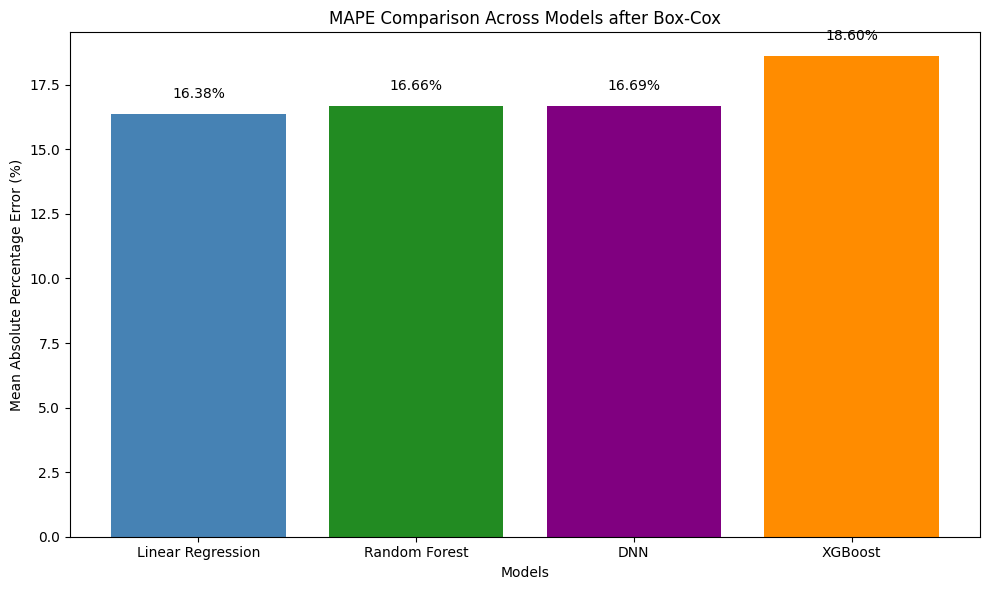

In [ ]:
# Making a visualization for the MAPEs

# Model names
models = ['Linear Regression', 'Random Forest', 'DNN', 'XGBoost']

# MAPE values
mapes = [mape_lr_bc, mape_rf_bc, mape_dnn_bc, mape_xgb_bc]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mapes, color=['steelblue', 'forestgreen', 'purple', 'darkorange'])

# Adding titles and labels
plt.title('MAPE Comparison Across Models after Box-Cox')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Percentage Error (%)')

# Display value labels on each bar
for i, mape in enumerate(mapes):
    plt.text(i, mape + 0.5, f'{mape:.2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

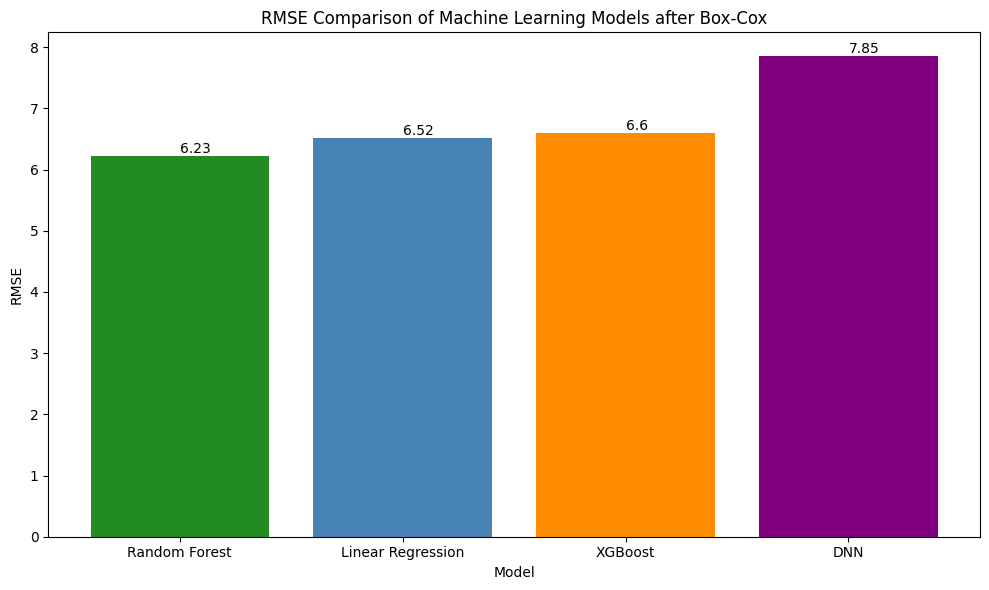

In [ ]:
# Visualizing RMSE for each BC model

best_rf_rmse_bc = sqrt(mse_rf_best_bc)
best_xgb_rmse_bc = sqrt(mse_xgb_best_bc)
best_dnn_rmse_bc = rmse_dnn_bc

# RMSE values obtained from models
model_names = ['Random Forest', 'Linear Regression', 'XGBoost', 'DNN']
rmse_values = [best_rf_rmse_bc, rmse_bc, best_xgb_rmse_bc, best_dnn_rmse_bc]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_values, color=['forestgreen', 'steelblue', 'darkorange', 'purple'], capsize=5)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Machine Learning Models after Box-Cox')

# Loop to add a label on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Displaying the plot
plt.xticks(model_names)
plt.tight_layout()
plt.show()

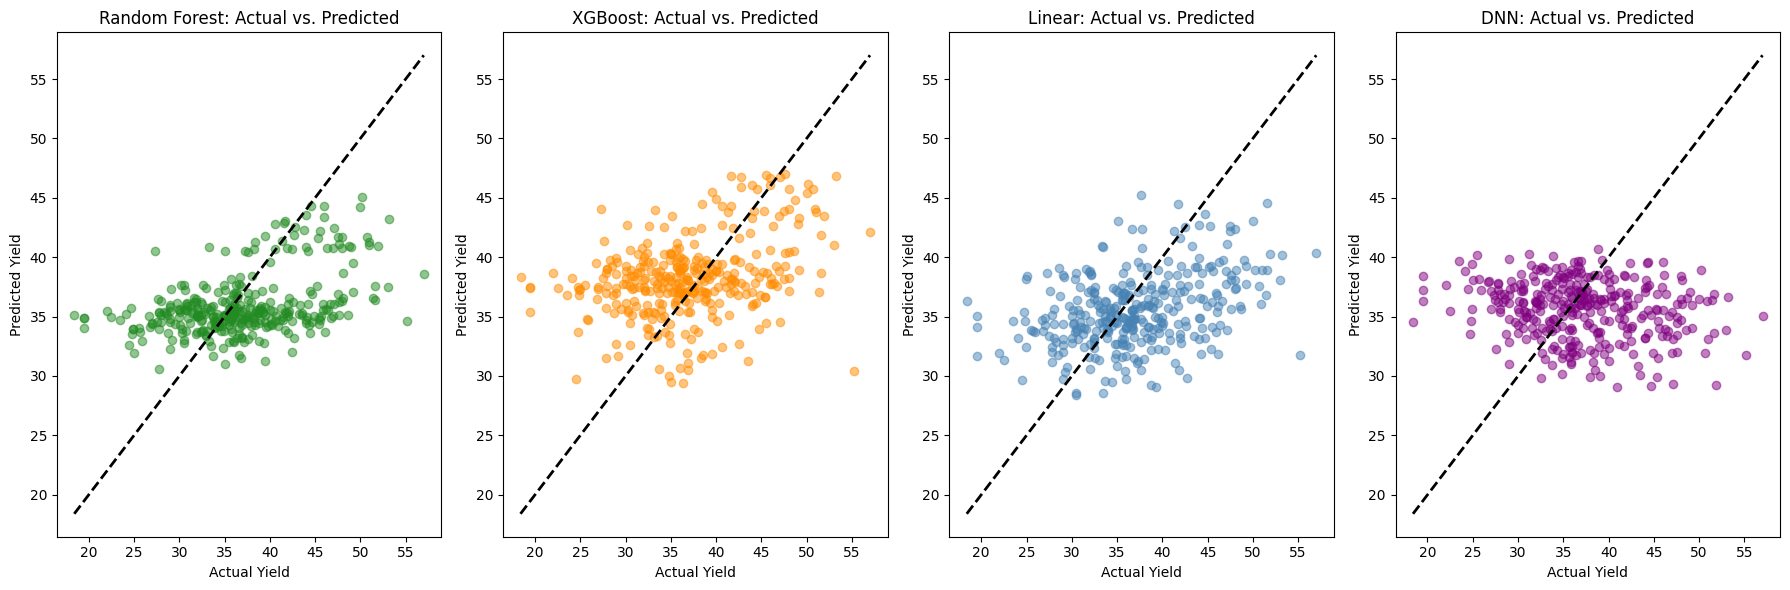

In [ ]:
# Scatterplots of Results

import matplotlib.pyplot as plt

y_pred_dnn_best = predictions
y_pred_linear_best = y_pred

# Creating separate scatter plots for each model
plt.figure(figsize=(18, 6))

# Random Forest
plt.subplot(1, 4, 1)
plt.scatter(y_test_bc, y_pred_rf_best_bc, alpha=0.5, label='Random Forest', color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# XGBoost
plt.subplot(1, 4, 2)
plt.scatter(y_test_bc, y_pred_xgb_best_bc, alpha=0.5, color='darkorange', label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# Linear
plt.subplot(1, 4, 3)
plt.scatter(y_test_bc, y_pred_bc.flatten(), alpha=0.5, color='steelblue', label='DNN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# DNN
plt.subplot(1, 4, 4)
plt.scatter(y_test_bc, y_pred_dnn_bc.flatten(), alpha=0.5, color='purple', label='DNN')  # Flatten y_pred_dnn if necessary
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('DNN: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

plt.tight_layout()
plt.show()

# Accompanying Results Visuals

In [ ]:
# Calculating the MAPEs

# Calculate the MAPE
mape_rf = np.mean(np.abs((y_test - y_pred_rf_best) / y_test)) * 100
mape_lr = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb_best) / y_test)) * 100
mape_dnn = np.mean(np.abs((y_test - y_pred_dnn.flatten()) / y_test)) * 100


print(f"Refined Random Forest MAPE: {mape_rf}%")
print(f"Refined Linear Regression MAPE: {mape_lr}%")
print(f"Refined XGBoost MAPE: {mape_xgb}%")
print(f"Refined DNN MAPE: {mape_dnn}%")

Refined Random Forest MAPE: 13.794689069048049%
Refined Linear Regression MAPE: 14.115917379565671%
Refined XGBoost MAPE: 14.697868957589638%
Refined DNN MAPE: 19.733983469619258%


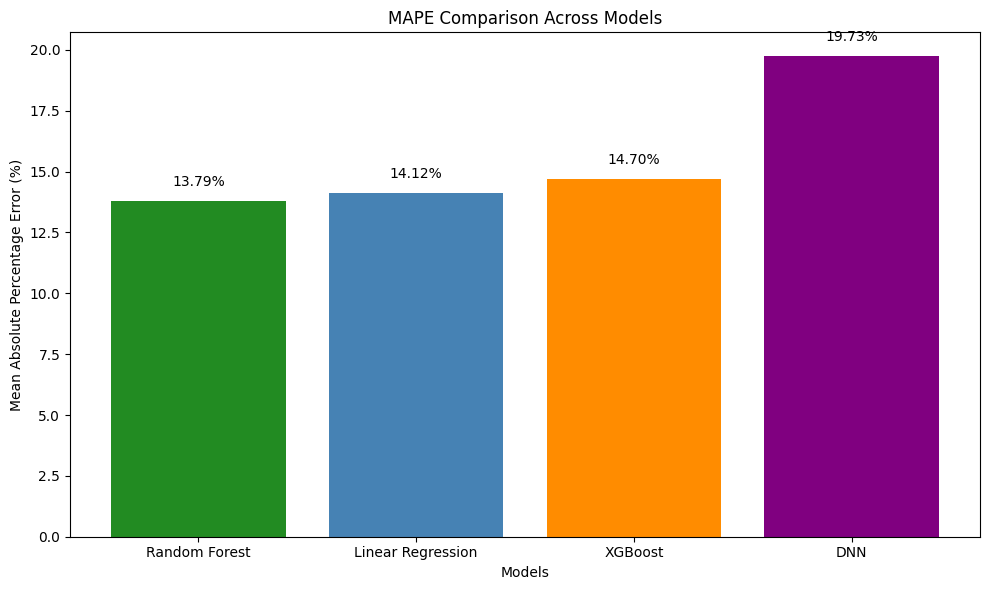

In [ ]:
# Making a visualization for the MAPEs

# Model names
models = ['Random Forest', 'Linear Regression', 'XGBoost', 'DNN']

# MAPE values
mapes = [mape_rf, mape_lr, mape_xgb, mape_dnn]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mapes, color=['forestgreen', 'steelblue', 'darkorange', 'purple'])

# Adding titles and labels
plt.title('MAPE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Percentage Error (%)')

# Display value labels on each bar
for i, mape in enumerate(mapes):
    plt.text(i, mape + 0.5, f'{mape:.2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


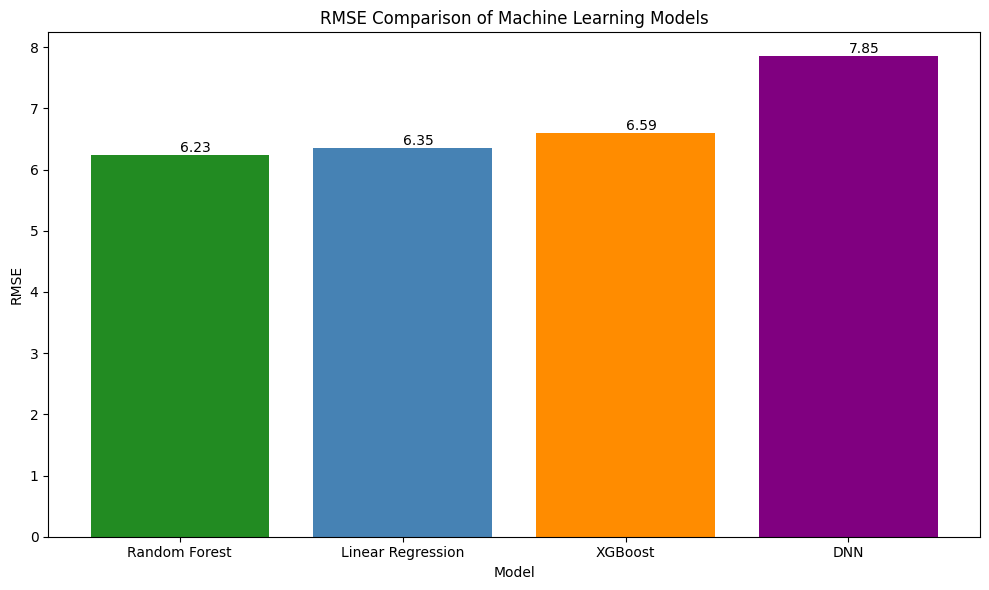

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the RMSE calculations have been done and these variables are initialized

# These values are set manually below based on a previous running of the models where progress was lost. If implementing this script for the first time, delete the next three lines
#best_rf_rmse = 6.23
#best_xgb_rmse = 6.59
#best_dnn_rmse = 7.85

# RMSE values obtained from models
model_names = ['Random Forest', 'Linear Regression', 'XGBoost', 'DNN']
rmse_values = [best_rf_rmse, rmse_linear, best_xgb_rmse, best_dnn_rmse]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_values, color=['forestgreen', 'steelblue', 'darkorange', 'purple'], capsize=5)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Machine Learning Models')

# Loop to add a label on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

# Displaying the plot
plt.xticks(model_names)
plt.tight_layout()
plt.show()


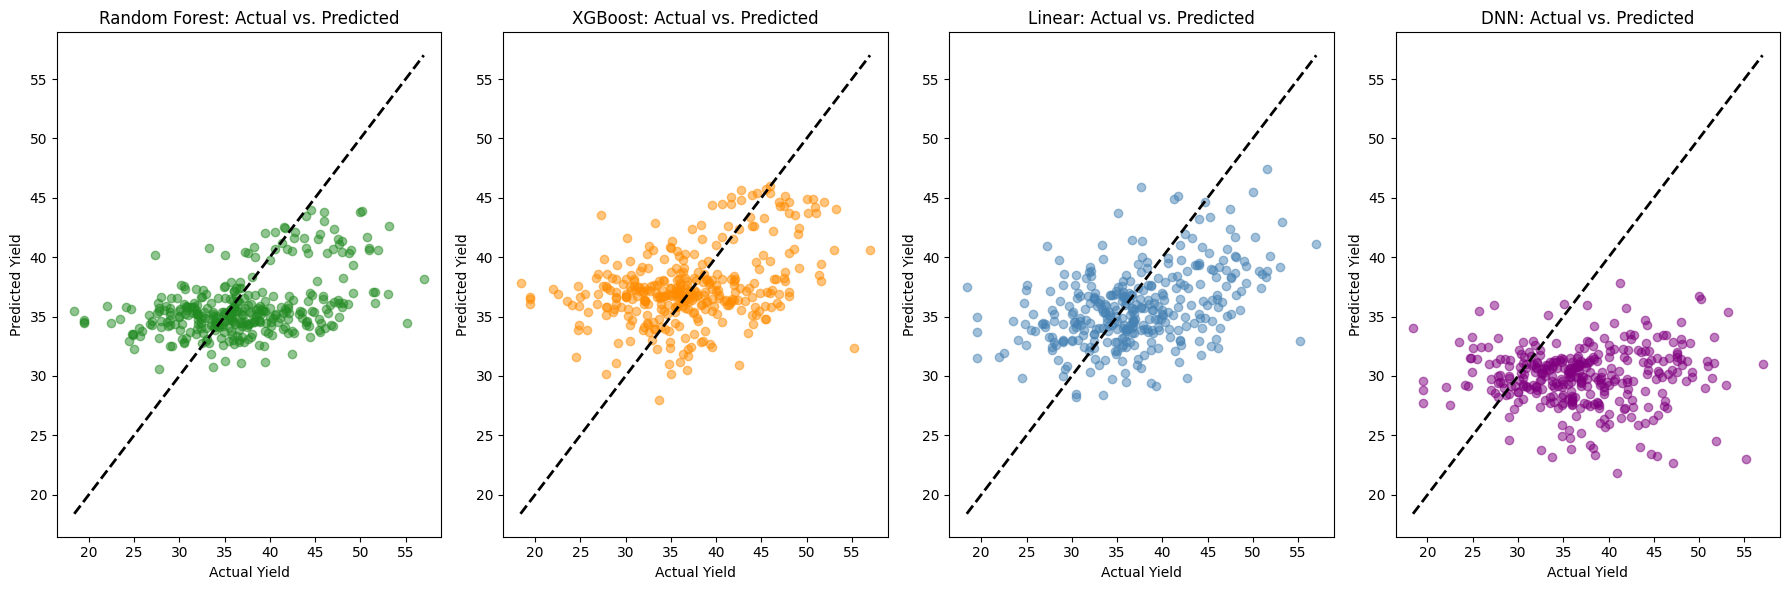

In [ ]:
# Scatterplots of Results

y_pred_dnn_best = predictions
y_pred_linear_best = y_pred

# Creating separate scatter plots for each model
plt.figure(figsize=(18, 6))

# Random Forest
plt.subplot(1, 4, 1)
plt.scatter(y_test, y_pred_rf_best, alpha=0.5, label='Random Forest', color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# XGBoost
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_xgb_best, alpha=0.5, color='darkorange', label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# Linear
plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_linear_best.flatten(), alpha=0.5, color='steelblue', label='DNN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

# DNN
plt.subplot(1, 4, 4)
plt.scatter(y_test, y_pred_dnn_best.flatten(), alpha=0.5, color='purple', label='DNN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('DNN: Actual vs. Predicted')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')

plt.tight_layout()
plt.show()